In [9]:
import hist
import boost_histogram as bh
import numpy as np
import mplhep as hep
import matplotlib.pyplot as plt
from utilities import boostHistHelpers as hh
from wremnants import histselections as sel
from wremnants import datasets2016
from wremnants import plot_tools
import wremnants
import lz4.frame
import pickle
hep.style.use(hep.style.ROOT)

In [10]:
with lz4.frame.open("../mw_with_mu_eta_pt.pkl.lz4") as f:
    boost = pickle.load(f)

In [11]:
wp = boost['WplusmunuPostVFP']['output']
wm = boost['WminusmunuPostVFP']['output']
print(wp.keys())

dict_keys(['MET_uncorr_pt', 'MET_uncorr_phi', 'METx_uncorr', 'METy_uncorr', 'MET_corr_lep_pt', 'MET_corr_lep_phi', 'METx_corr_lep', 'METy_corr_lep', 'MET_corr_xy_pt', 'MET_corr_xy_phi', 'METx_corr_xy', 'METy_corr_xy', 'METx_corr_lep_npv', 'METy_corr_lep_npv', 'METx_corr_xy_npv', 'METy_corr_xy_npv', 'recoil_corr_xy_magn_gen', 'recoil_corr_xy_para_gen', 'recoil_corr_xy_para_qT_gen', 'recoil_corr_xy_perp_gen', 'recoil_corr_xy_para_qT_perp_gen', 'recoil_corr_xy_magn_qTbinned_gen', 'recoil_corr_xy_para_qTbinned_gen', 'recoil_corr_xy_para_qT_qTbinned_gen', 'recoil_corr_xy_perp_qTbinned_gen', 'qT_gen', 'mTStudyForFakes', 'nominal_weight', 'nominal', 'nominal_cvh', 'nominal_uncrct', 'nominal_gen', 'nominal_gen_smeared', 'nominal_qcdJetPt45', 'nominal_effStatTnP_sf_reco', 'nominal_effStatTnP_sf_tracking', 'nominal_effStatTnP_sf_idip', 'nominal_effStatTnP_sf_trigger', 'nominal_effStatTnP_sf_iso_effData', 'nominal_effStatTnP_sf_iso_effMC', 'nominal_effSystTnP', 'nominal_muonL1PrefireStat', 'nomin

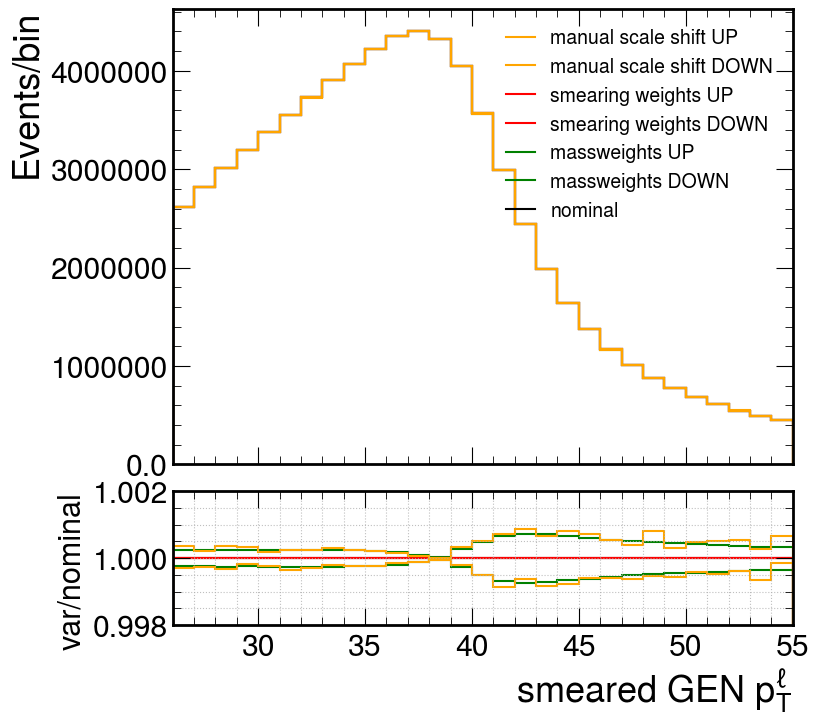

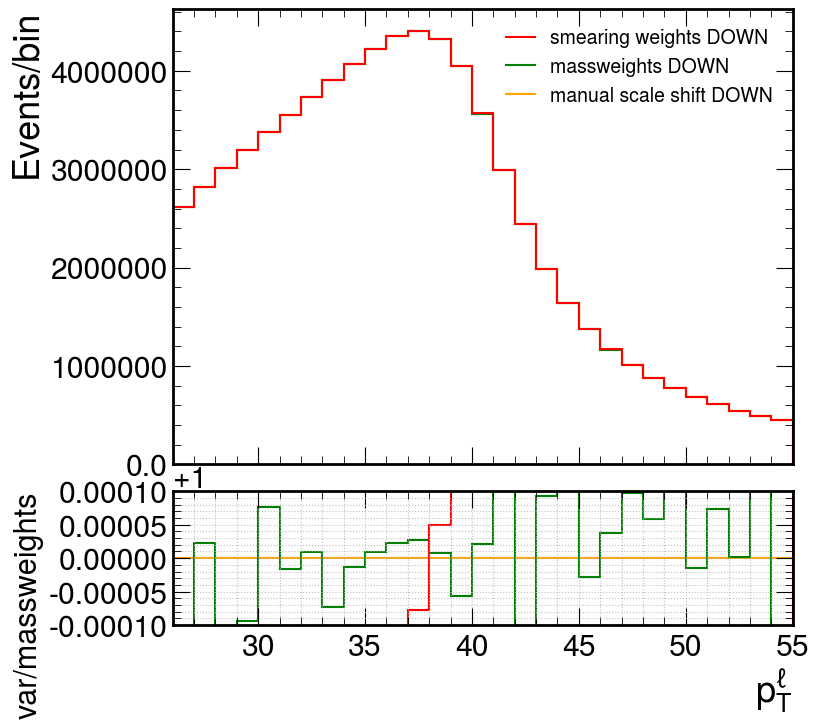

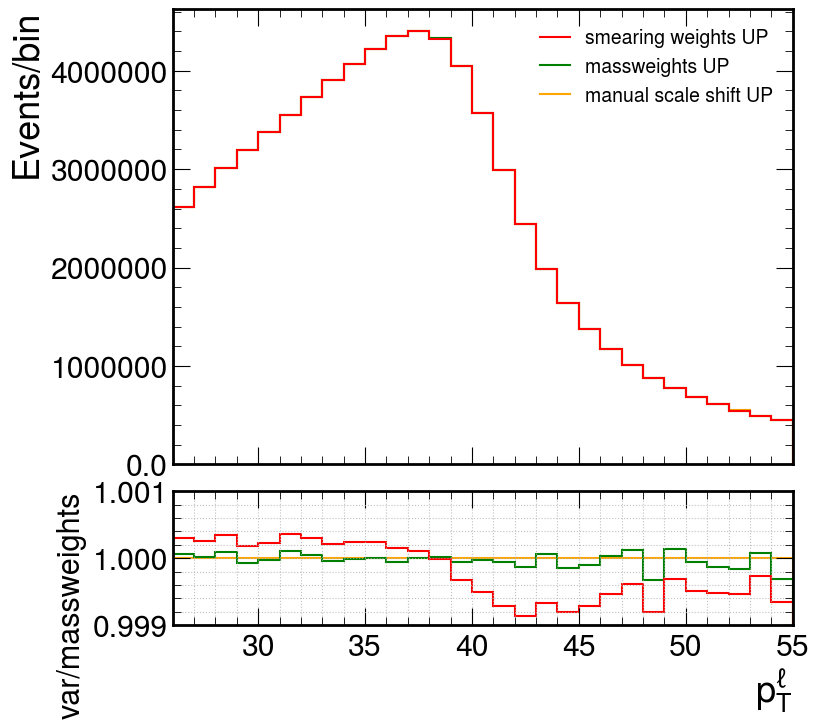

In [21]:
action = lambda x: x.project('pt')
#action = lambda x: sel.unrolledHist(x)

nominal = action(wp['nominal_gen_smeared'][{'charge':1j}])
ms_from_massweights = [action(wp['nominal_muonScaleSyst_gen_smear'][{'charge':1j}][...,0,0]), 
                       action(wp['nominal_muonScaleSyst_gen_smear'][{'charge':1j}][...,1,0])]
ms_from_smearing = [action(wp['muonScaleSyst_responseWeights_gensmear'][{'charge':1j}][...,1,0]), 
                    action(wp['muonScaleSyst_responseWeights_gensmear'][{'charge':1j}][...,1,1])]
ms_from_scale_var = [action(wp['nominal_muonScaleVariationDnTenthmil_gen_smear'][{'charge':1j}]),
                     action(wp['nominal_muonScaleVariationUpTenthmil_gen_smear'][{'charge':1j}])]
fig = plot_tools.makePlotWithRatioToRef(
    [
        nominal,
        ms_from_massweights[0],
        ms_from_massweights[1],
        ms_from_smearing[0],
        ms_from_smearing[1],
        ms_from_scale_var[0],
        ms_from_scale_var[1]#* nominal.sum().value / ms_from_scale_var.sum().value
    ],
    labels = [
        'nominal', 
        'massweights DOWN',
        'massweights UP',
        'smearing weights DOWN',
        'smearing weights UP',
        'manual scale shift DOWN',
        'manual scale shift UP'
    ],
    colors = ['black', 'green', 'green', 'red', 'red', 'orange', 'orange'],
    rrange = [0.998, 1.002],
    nlegcols = 1,
    rlabel = 'var/nominal',
    xlabel = r'smeared GEN $p_T^{\ell}$',
    grid = True
)


fig = plot_tools.makePlotWithRatioToRef(
    [
        ms_from_scale_var[0],
        ms_from_massweights[0],
        ms_from_smearing[0] #* ms_from_massweights[0].sum().value/ ms_from_smearing[0].sum().value,
        
    ],
    labels = [ 
        'manual scale shift DOWN',
        'massweights DOWN',
        'smearing weights DOWN'
        
    ],
    colors = ['orange','green', 'red'],
    rrange = [0.9999, 1.0001],
    nlegcols = 1,
    rlabel = 'var/massweights',
    xlabel = r'$p_T^{\ell}$',
    grid = True
)

fig = plot_tools.makePlotWithRatioToRef(
    [
        ms_from_scale_var[1],
        ms_from_massweights[1],
        ms_from_smearing[1] #* ms_from_massweights[0].sum().value/ ms_from_smearing[0].sum().value,
        
    ],
    labels = [ 
        'manual scale shift UP',
        'massweights UP',
        'smearing weights UP'
        
    ],
    colors = ['orange','green', 'red'],
    rrange = [0.999, 1.001],
    nlegcols = 1,
    rlabel = 'var/massweights',
    xlabel = r'$p_T^{\ell}$',
    grid = True
)


In [13]:
import uproot
import hist
import numpy as np
from wremnants import muon_validation

n_scale_params = 3
n_tot_params = 4
n_eta_bins = 24
filepath = "../wremnants/data/calibration/calibrationJMC_smeared_v718_nominal.root"

f = uproot.open(filepath)
cov = f['covariance_matrix'].to_hist()
cov_scale_params = muon_validation.get_jpsi_scale_param_cov_mat(cov, n_scale_params, n_tot_params, n_eta_bins)

w,v = np.linalg.eigh(cov_scale_params)
var_mat = np.sqrt(w) * v
axis_eta = hist.axis.Regular(n_eta_bins, -2.4, 2.4, name = 'eta')
axis_scale_params = hist.axis.Regular(n_scale_params, 0, 1, name = 'scale_params')
axis_scale_params_unc = hist.axis.Regular(
    n_eta_bins * n_scale_params, 0, n_eta_bins * n_scale_params,
    underflow = False, overflow = False,  name = 'unc'
)
hist_scale_params_unc = hist.Hist(axis_eta, axis_scale_params, axis_scale_params_unc)
for i in range(n_eta_bins):
    lb, ub = i * n_scale_params, (i + 1) * n_scale_params
    hist_scale_params_unc.view()[i,...] = var_mat[lb:ub][:]



In [8]:
wp['muonScaleSyst_responseWeights']

Hist(
  Regular(48, -2.4, 2.4, name='eta'),
  Regular(29, 26, 55, name='pt'),
  Regular(2, -2, 2, underflow=False, overflow=False, name='charge'),
  Boolean(name='passIso'),
  Boolean(name='passMT'),
  Regular(2, -2, 2, underflow=False, overflow=False, name='downUpVar'),
  storage=Weight()) # Sum: WeightedSum(value=1.43695e+08, variance=5.46134e+08) (WeightedSum(value=1.65488e+08, variance=6.23668e+08) with flow)

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f3d1dcb3550>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f3d34984580>, text=[])

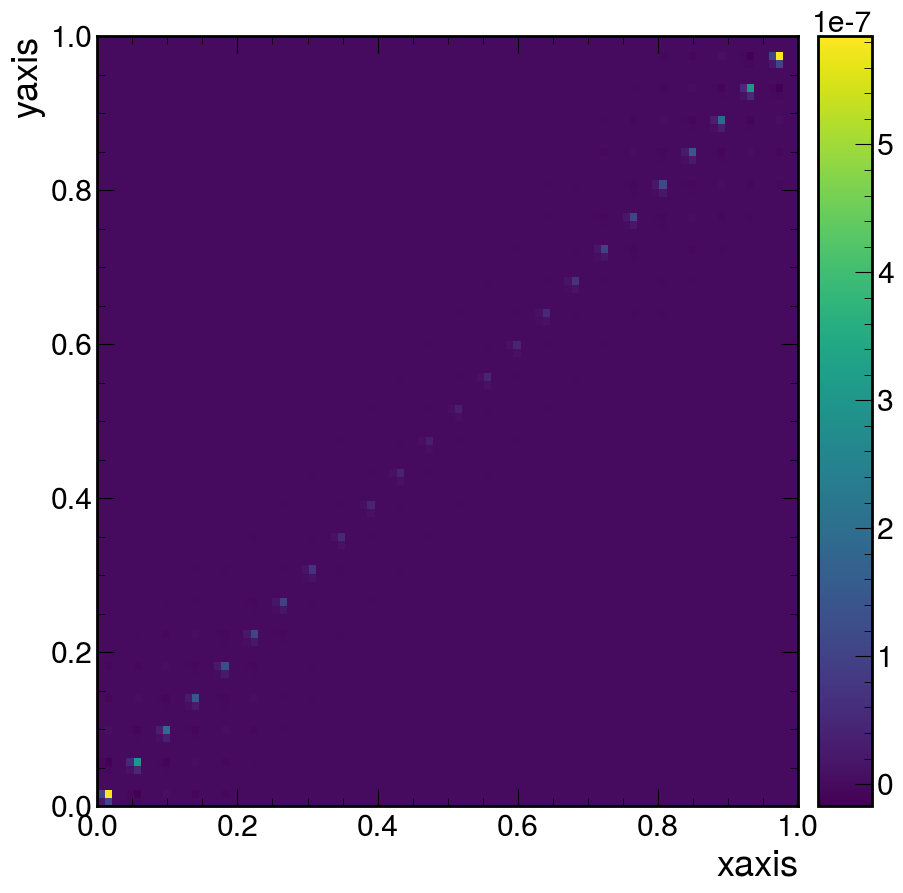

In [22]:
hep.hist2dplot(cov)

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f3d1930b8b0>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f3d19309450>, text=[])

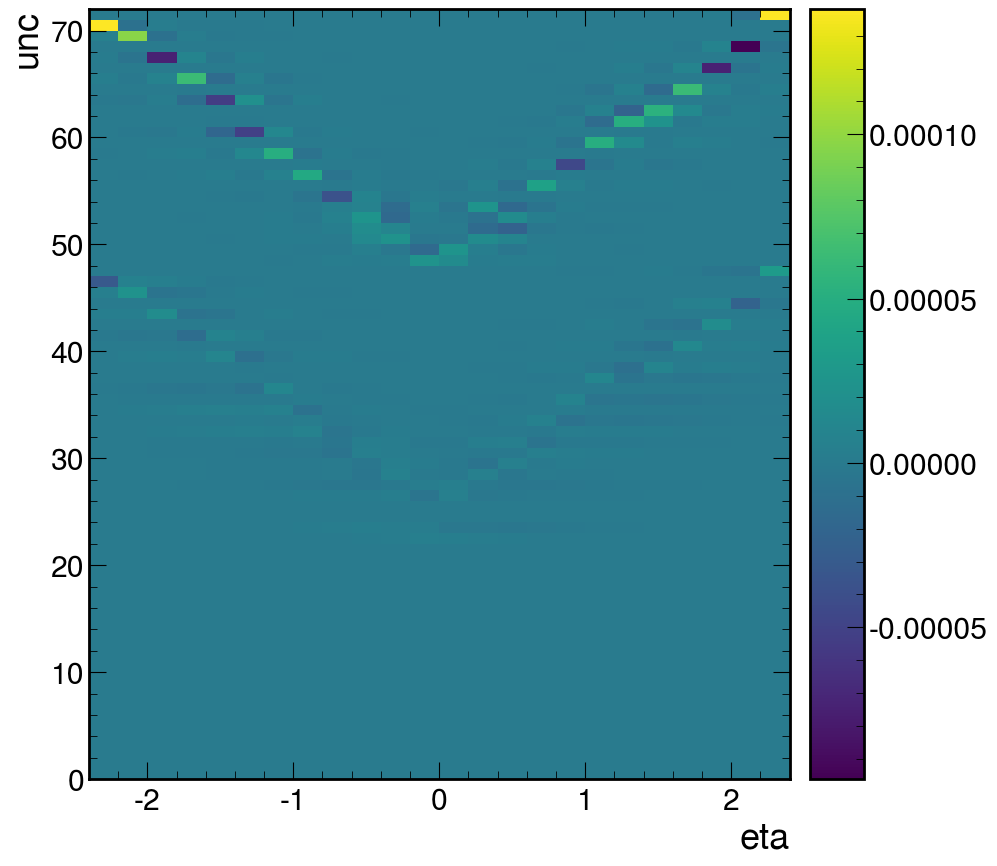

In [23]:
hep.hist2dplot(hist_scale_params_unc[{'scale_params':0}])

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f3d34e7ac50>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f3d177a51e0>, text=[])

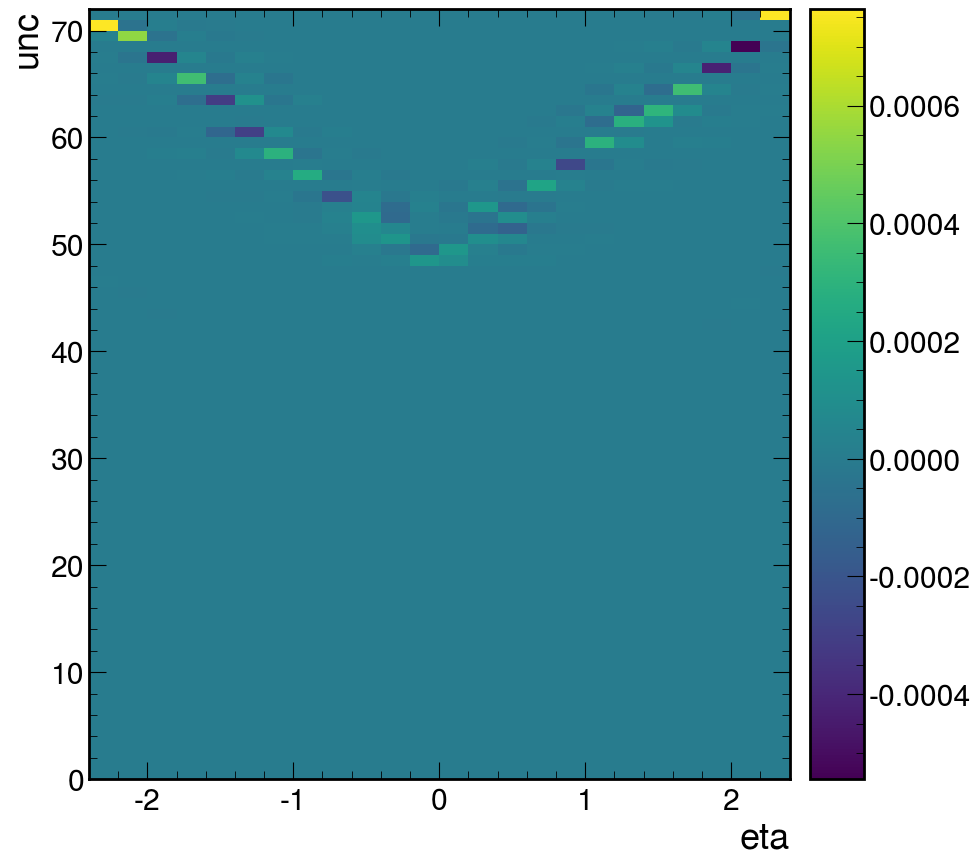

In [24]:
hep.hist2dplot(hist_scale_params_unc[{'scale_params':1}])

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f48925440d0>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f48948e70a0>, text=[])

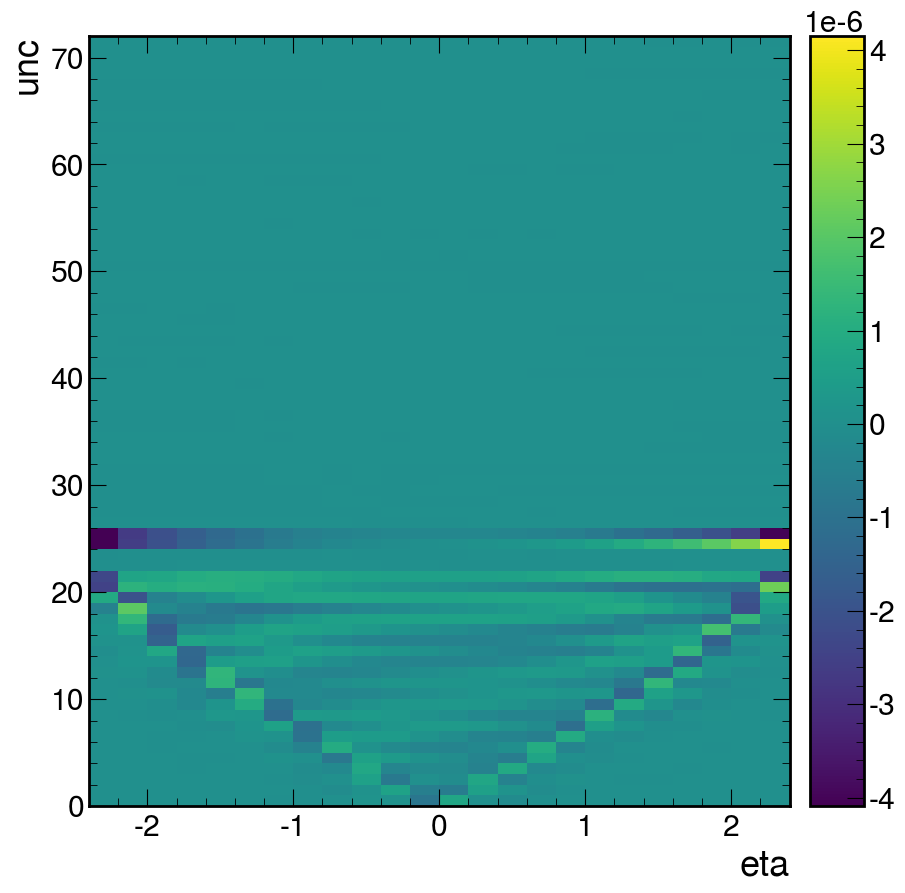

In [30]:
hep.hist2dplot(hist_scale_params_unc[{'scale_params':2}])

varsqd dn/up in bin 16 is: 0.9999997994885891 in variable # 0
varsqd dn/up in bin 16 is: 0.9999994729415792 in variable # 1
varsqd dn/up in bin 16 is: 1.0000441168147693 in variable # 2
varsqd dn/up in bin 16 is: 0.9999760074595124 in variable # 3
varsqd dn/up in bin 16 is: 1.0000200639622199 in variable # 4
varsqd dn/up in bin 16 is: 0.9997174875313074 in variable # 5
varsqd dn/up in bin 16 is: 1.0001184380412695 in variable # 6
varsqd dn/up in bin 16 is: 1.0000254443607624 in variable # 7
varsqd dn/up in bin 16 is: 0.9999408950342747 in variable # 8
varsqd dn/up in bin 16 is: 1.0000265773830235 in variable # 9
varsqd dn/up in bin 16 is: 1.0001405093415927 in variable # 10
varsqd dn/up in bin 16 is: 0.9999520267277251 in variable # 11
varsqd dn/up in bin 16 is: 0.9997755322534213 in variable # 12
varsqd dn/up in bin 16 is: 1.0001494587897364 in variable # 13
varsqd dn/up in bin 16 is: 0.9997739789491362 in variable # 14
varsqd dn/up in bin 16 is: 1.0001754107647616 in variable # 15
va

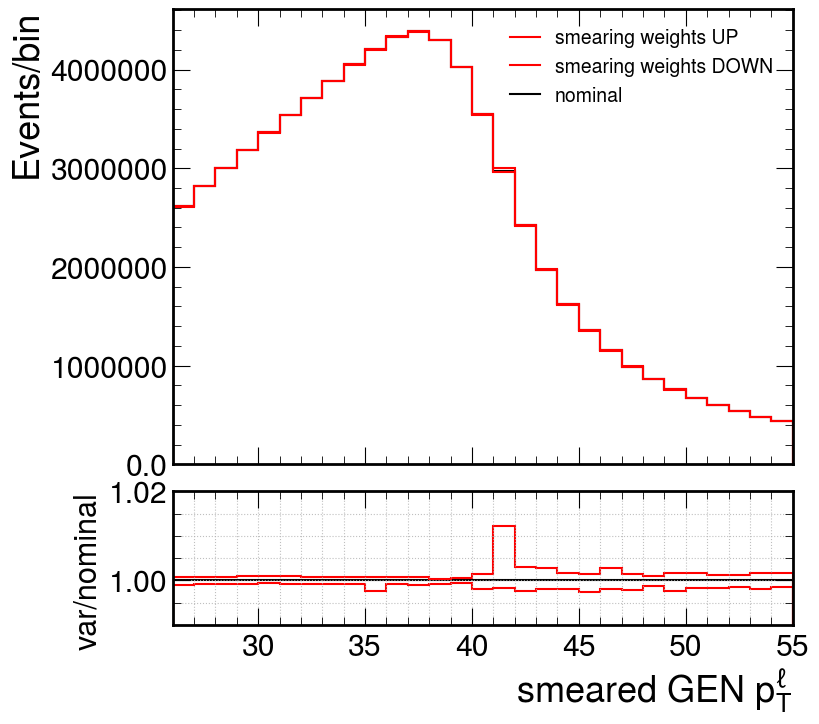

In [27]:
swv = wp['muonScaleSyst_responseWeights_gensmear']

for i in range(swv[0,0,0,0,0,...,0].size - 2):
    var_h_dn = hh.addHists(swv[{'charge':1j, 'downUpVar':0, 'unc':i}].project('pt'), -1 * nominal)
    var_h_up = hh.addHists(swv[{'charge':1j, 'downUpVar':1, 'unc':i}].project('pt'), -1 * nominal)
    varsqd_h_dn = hh.multiplyHists(var_h_dn, var_h_dn)
    varsqd_h_up = hh.multiplyHists(var_h_up, var_h_up)
    print('varsqd dn/up in bin 16 is:',  varsqd_h_dn[15].value/varsqd_h_up[15].value, 'in variable #', i)
    if i == 0:
        tot_varsqd_h_dn = varsqd_h_dn 
        tot_varsqd_h_up = varsqd_h_up
    else: 
        tot_varsqd_h_dn = hh.addHists(tot_varsqd_h_dn, varsqd_h_dn)
        tot_varsqd_h_up = hh.addHists(tot_varsqd_h_up, varsqd_h_up)
tot_var_h_dn = hh.sqrtHist(tot_varsqd_h_dn)
tot_var_h_up = hh.sqrtHist(tot_varsqd_h_up)

h_dn = hh.addHists(nominal, -1 * tot_var_h_dn)
h_up = hh.addHists(nominal, tot_var_h_up)

fig = plot_tools.makePlotWithRatioToRef(
    [
        nominal,
        h_dn,
        h_up
    ],
    labels = [
        'nominal', 
        'smearing weights DOWN',
        'smearing weights UP',
    ],
    colors = ['black','red', 'red'],
    rrange = [0.99, 1.02],
    nlegcols = 1,
    rlabel = 'var/nominal',
    xlabel = r'smeared GEN $p_T^{\ell}$',
    grid = True
)    

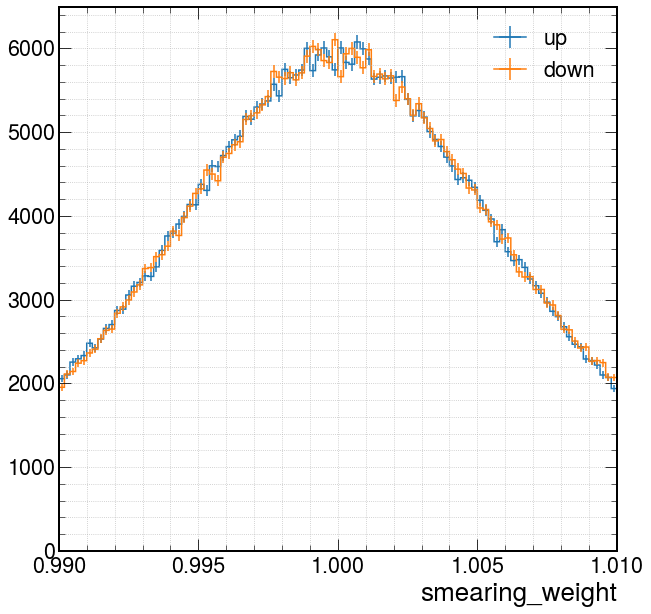

In [27]:
fig, ax = plt.subplots()
hep.histplot(wp['smearing_weights_up'].project('smearing_weight'), label = "up", ax=ax)
hep.histplot(wp['smearing_weights_down'].project('smearing_weight'), label = "down", ax=ax)
ax.legend()
ax.set_xlim(0.99,1.01)
ax.grid(which='both')

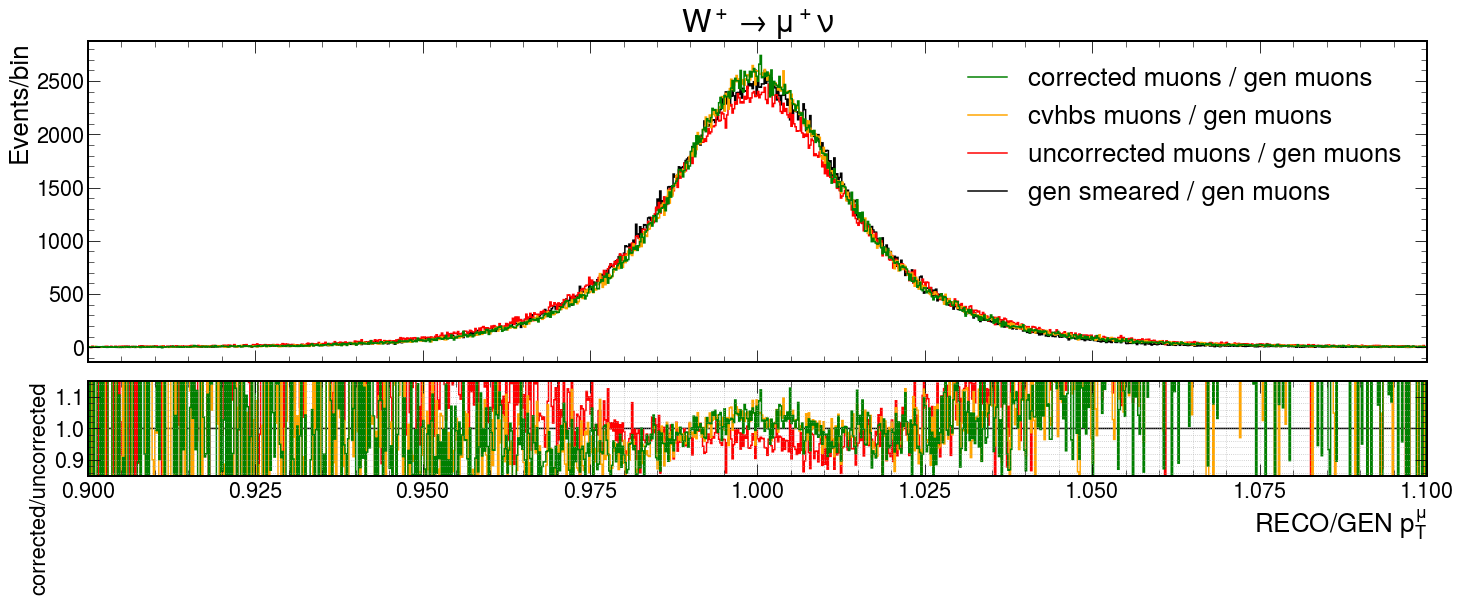

In [28]:
wp_label = r'$W^+ \rightarrow \mu^+ \nu$' 
fig = plot_tools.makePlotWithRatioToRef(
    [
        wp['gen_smeared_over_gen'].project('reco_pt_over_gen'),
        wp['uncrct_over_gen'].project('reco_pt_over_gen'),
        wp['cvhbs_over_gen'].project('reco_pt_over_gen'),
        wp['crctd_over_gen'].project('reco_pt_over_gen')
    ],
    labels = [ 
        'gen smeared / gen muons',
        'uncorrected muons / gen muons',
        'cvhbs muons / gen muons',
        'corrected muons / gen muons'
    ],
    colors = ['black','red', 'orange', 'green'],
    rrange = [0.85, 1.15],
    nlegcols = 1,
    rlabel = 'corrected/uncorrected',
    xlabel = r'RECO/GEN $p_T^{\mu}$',
    #xlim = [0.9995, 1.0005],
    grid = True,
    bin_density = 400,
    x_ticks_ndp = 3,
    plot_title = wp_label
)

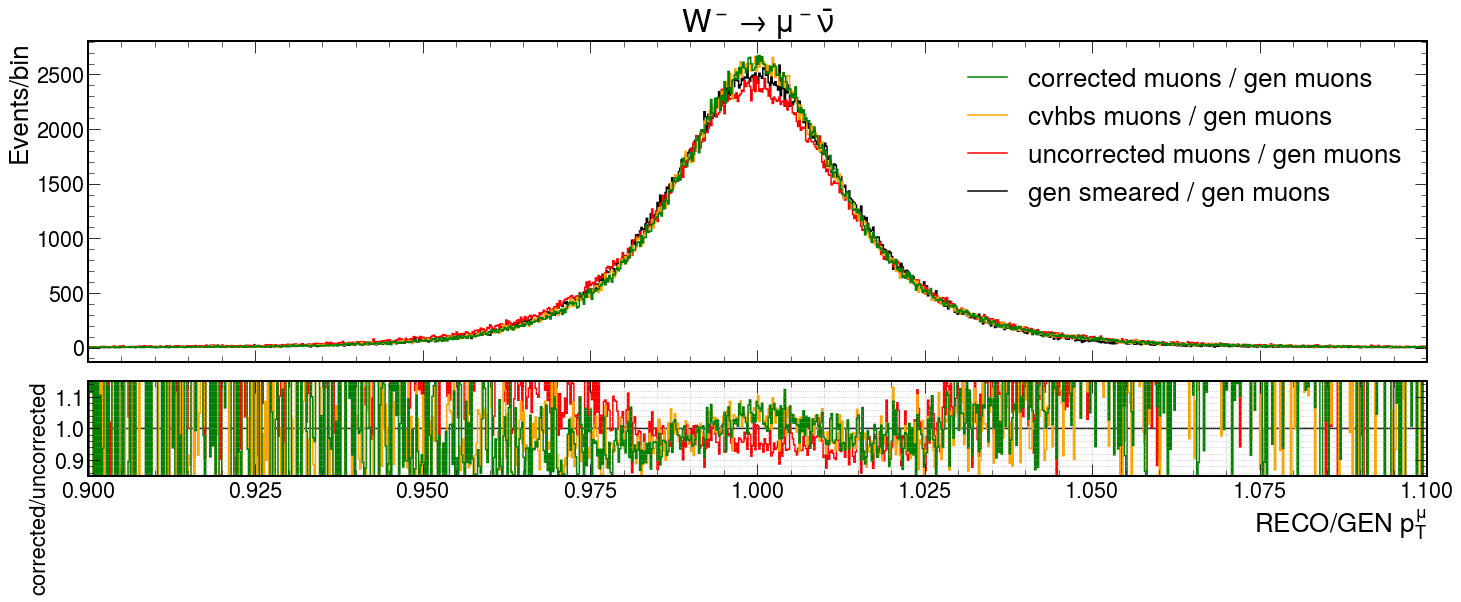

In [29]:
wm_label = r'$W^- \rightarrow \mu^- \bar{\nu}$' 
fig = plot_tools.makePlotWithRatioToRef(
    [
        wm['gen_smeared_over_gen'].project('reco_pt_over_gen'),
        wm['uncrct_over_gen'].project('reco_pt_over_gen'),
        wm['cvhbs_over_gen'].project('reco_pt_over_gen'),
        wm['crctd_over_gen'].project('reco_pt_over_gen')
    ],
    labels = [ 
        'gen smeared / gen muons',
        'uncorrected muons / gen muons',
        'cvhbs muons / gen muons',
        'corrected muons / gen muons'
    ],
    colors = ['black','red', 'orange', 'green'],
    rrange = [0.85, 1.15],
    nlegcols = 1,
    rlabel = 'corrected/uncorrected',
    xlabel = r'RECO/GEN $p_T^{\mu}$',
    #xlim = [0.9995, 1.0005],
    grid = True,
    bin_density = 400,
    x_ticks_ndp = 3,
    plot_title = wm_label
)

Hist(
  Regular(29, 26, 55, name='pt', label='pt'),
  Regular(48, -2.4, 2.4, name='eta', label='eta'),
  storage=Weight()) # Sum: WeightedSum(value=398568, variance=491711) (WeightedSum(value=459008, variance=561876) with flow)


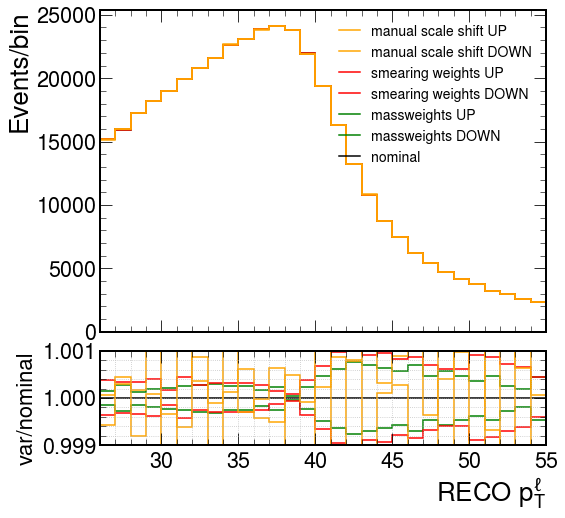

In [30]:
nominal_gen_smearing = wp['nominal_gen_smeared'][{'charge':1j}].project('pt', 'eta')
print(nominal_gen_smearing)

gen_smeared_msv_from_sw = [wp['muonScaleSyst_responseWeights_gensmear'][{'charge':1j}][...,0,0].project('pt', 'eta'), 
                           wp['muonScaleSyst_responseWeights_gensmear'][{'charge':1j}][...,0,1].project('pt', 'eta')]
smearing_weights_per_bin_up = hh.divideHists(gen_smeared_msv_from_sw[0], nominal_gen_smearing)
smearing_weights_per_bin_dn = hh.divideHists(gen_smeared_msv_from_sw[1], nominal_gen_smearing)

nominal_reco = wp['nominal'][{'charge':1j}].project('pt', 'eta')
msv_reco_massweights = [wp['muonScaleSyst'][{'charge':1j}][...,0,0].project('pt', 'eta'), 
                        wp['muonScaleSyst'][{'charge':1j}][...,1,0].project('pt', 'eta')]
msv_reco_manual = [wp['muonScaleVariationDnTenthmil'][{'charge':1j}].project('pt', 'eta'), 
                   wp['muonScaleVariationUpTenthmil'][{'charge':1j}].project('pt', 'eta')]
#msv_reco_sw = [hh.multiplyHists(nominal_reco, smearing_weights_per_bin_dn),
#               hh.multiplyHists(nominal_reco, smearing_weights_per_bin_up)]

msv_reco_sw = [wp['muonScaleSyst_responseWeights'][...,0], wp['muonScaleSyst_responseWeights'][...,1]]
fig = plot_tools.makePlotWithRatioToRef(
    [
        action(nominal_reco),
        action(msv_reco_massweights[0]),
        action(msv_reco_massweights[1]),
        action(msv_reco_sw[0]),
        action(msv_reco_sw[1]),
        action(msv_reco_manual[0]),
        action(msv_reco_manual[1])#* nominal.sum().value / ms_from_scale_var.sum().value
    ],
    labels = [
        'nominal', 
        'massweights DOWN',
        'massweights UP',
        'smearing weights DOWN',
        'smearing weights UP',
        'manual scale shift DOWN',
        'manual scale shift UP'
    ],
    colors = ['black', 'green', 'green', 'red','red', 'orange', 'orange'],
    rrange = [0.999, 1.001],
    nlegcols = 1,
    rlabel = 'var/nominal',
    xlabel = r'RECO $p_T^{\ell}$',
    grid = True
)

In [31]:
proj_axes = ['pt', 'eta']
a = wp['muonScaleSyst_gen_smear'].project(*proj_axes)
print(a.axes)
a.project('pt')
#print(wp['muonScaleSyst_gen_smear'][{'pt':hist.loc(26)}].project('pt'))

(Regular(29, 26, 55, name='pt', label='pt'), Regular(48, -2.4, 2.4, name='eta', label='eta'))


Hist(Regular(29, 26, 55, name='pt', label='pt'), storage=Weight()) # Sum: WeightedSum(value=797188, variance=983518) (WeightedSum(value=918011, variance=1.12377e+06) with flow)

In [32]:
proc = 'WplusmunuPostVFP'
print(any([x in proc for x in ['mlus', 'Plus']]))

False


In [33]:
wp['muonScaleSyst_responseWeights']

Hist(
  Regular(29, 26, 55, name='pt', label='pt'),
  Regular(48, -2.4, 2.4, name='eta', label='eta'),
  Regular(2, -2, 2, underflow=False, overflow=False, name='downUpVar', label='downUpVar'),
  storage=Weight()) # Sum: WeightedSum(value=797499, variance=2.96158e+06) (WeightedSum(value=918025, variance=3.38078e+06) with flow)